# Face Classification with ResNet18


*   Face Recognition: Self-designed CNN model to tackle the problem of classification, consisting of 7001 identities.


**Structure of this notebook and meaning of every section**:

1. **Libraries** - just run it
2. **Kaggle** - copy the code from HW1P2 and add a correct API key
3. **Configs** - specify your configs
4. **Dataset**
  - **Datasets and Dataloaders** - it's already implemented, just specify your preferred augmentations/transformations
  - **EDA and Viz** - just run it to check if your augmentations/transformations worked
5. **Model Architecture** - implement and define your preferred model architecture
6. **Loss, Optimizer, and Scheduler** - define your loss, optimizer, and a scheduler
7. **Training and Validation Functions** - includes functions for both classification and verification tasks
8. **Wandb** - add a correct API key
9. **Experiments** - make changes if needed; it will show you train/val/test accuracy for both classification and verification. **Important**: make sure you save your best model checkpoints because models in this HW take a long time to get trained
10. **Testing and Kaggle Submission** - just run it



# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

Wed Mar  6 22:42:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#NOTE: RESTART THE RUN TIME AFTER RUNNING THE THE CELL BELOW

In [ ]:
!pip install 'urllib3<1.27,>=1.25.4' --force-reinstall
!pip install torchsummary
!pip install tqdm
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install --upgrade kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.6-py3-none-any.whl size=111943 sha256=4a373c470bd371a996dad1b88d75b62d412d039bd5a14778d836835f1e50bd18
  Stored in directory: /root/.cache/pip/wheels/53/34/8c/8ca3450d17206d9e37e1ee3aeb47cbb2873d22a9e0c60eb137
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [2]:
# Install the necessary packages. Very important: Please restart your session in Colab/Local Machine
# You can restart your session in colab by going to Runtime and then clicking restart session
!pip install wandb --quiet


In [ ]:
# Import the important packages
import torch
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Device:  cuda


# Kaggle

In [12]:
#necessary imports to make Kaggle file for tracking the progress
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
import os
kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
with open(kaggle_json_path, "w") as f:
    f.write('{"username":"","key":""}')

Processing /home/ubuntu/.cache/pip/wheels/f3/67/7b/a6d668747974998471d29b230e7221dd01330ac34faebe4af4/kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [ ]:
#Data downloading step
!mkdir '/home/ubuntu/hw2p2_resnet/data'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '/home/ubuntu/hw2p2_resnet/data'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '/home/ubuntu/hw2p2_resnet/data'

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
 99%|██████████████████████████████████████▋| 1.70G/1.71G [00:07<00:00, 297MB/s]
100%|███████████████████████████████████████| 1.71G/1.71G [00:08<00:00, 228MB/s]
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
 36%|█████████████▌                        | 6.00M/16.8M [00:00<00:00, 58.6MB/s]
100%|███████████████████████████████████████| 16.8M/16.8M [00:00<00:00, 119MB/s]


# Configs

In [70]:
config = {
    'batch_size': 96, # Increase this if your GPU can handle it
    'lr': 5e-3,
    'epochs': 100, # 20 epochs 
}

# Dataset

## Datasets and Dataloaders

In [16]:
import os

In [75]:
# --------------------------------------------------- #
# Data paths

DATA_DIR    = "/home/ubuntu/hw2p2_resnet/data/11-785-s24-hw2p2-classification" # TODO: Path where you have downloaded the classificaation data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    torchvision.transforms.RandomRotation(20),      # Random rotation
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    torchvision.transforms.Resize((224, 224)),      # Resize images to 224x224
    torchvision.transforms.ToTensor(),              # Convert images to Tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ]) 

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
"""

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize images to 224x224
    torchvision.transforms.ToTensor(),          # Convert images to Tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 4, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           num_workers = 2 # Uncomment this line if you want to increase your num workers
                                           )

In [76]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 2 # Uncomment this line if you want to increase your num workers
                                          )

## EDA and Viz

In [77]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  96
Train batches        :  1459
Val batches          :  365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

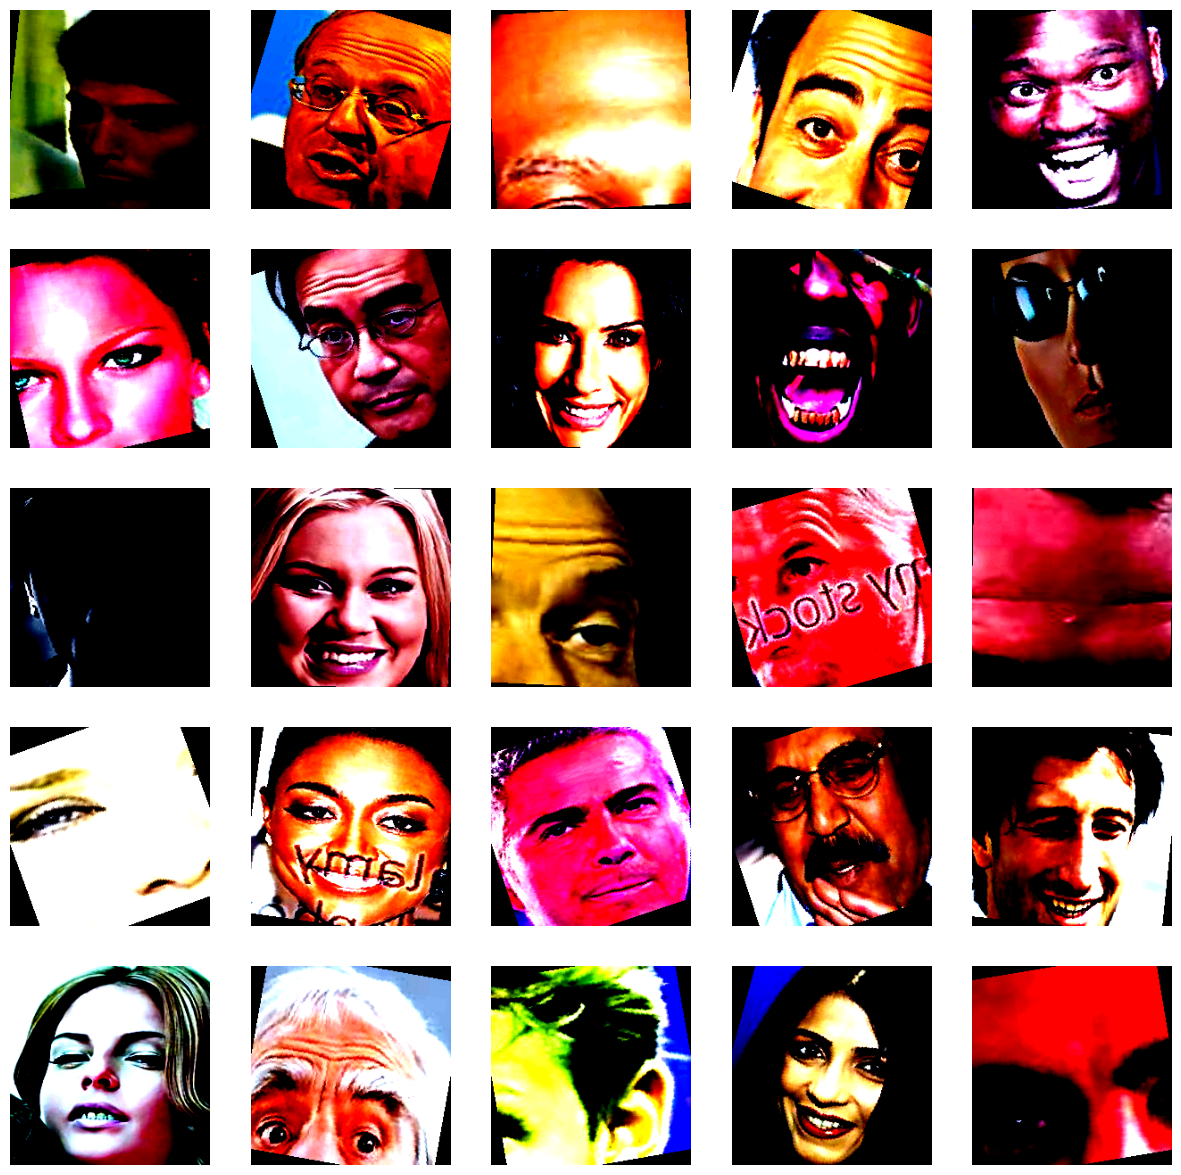

In [78]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next four have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 224x224. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [79]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7001):  # Adjusted num_classes as per your dataset
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, return_feats=False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        feats = out.view(out.size(0), -1)  # This is the feature vector you might want to use for your verification task

        if return_feats:
            return feats  # Return the features if return_feats is True

        out = self.linear(feats)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


model = ResNet18()
model.to(DEVICE)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [81]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming your model is already defined and initialized as 'model'
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

# Check if the total number of parameters exceeds 18 million
if total_params > 18e6:
    print("The model exceeds the 18 million parameter limit.")
else:
    print("The model is within the 18 million parameter limit.")


Total trainable parameters: 14760345
The model is within the 18 million parameter limit.


# Loss, Optimizer, and Scheduler Definition

In [82]:
# # --------------------------------------------------- #

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
# Defining Loss function
# criterion = # TODO: What loss do you need for a multi class classification problem and would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
# Alternatively, you might want to try Adam or AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

#--------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Training and Validation Functions

## Classification Task

In [83]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [84]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [85]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [86]:
# This obtains the list of known identities from the known folder
known_regex = "/home/ubuntu/hw2p2_resnet/data/11-785-s24-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/home/ubuntu/hw2p2_resnet/data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/home/ubuntu/hw2p2_resnet/data/11-785-s24-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]


transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 12503.90it/s]


In [87]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE)) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE))

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)
    print(np.shape(unknown_feats), np.shape(known_feats))

    # similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?
    similarity_matrix = []
    for unknown_feat in unknown_feats:
        similarity_row = similarity(unknown_feat.unsqueeze(0), known_feats)
        similarity_matrix.append(similarity_row)
    similarity_values = torch.stack(similarity_matrix)

    max_similarity_values, predictions = similarity_values.max(dim=1) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()

    threshold = 0.4 # Choose a proper threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('/home/ubuntu/hw2p2_resnet/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      # print(len(pred_id_strings), len(true_ids))
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))

      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [120]:
true_ids = pd.read_csv('/content/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()

In [88]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [89]:
wandb.login(key="") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [90]:
# Create your wandb run
run = wandb.init(
    name = "hw2p2_aws_rereun_new_p3_after67_more_transformmmmmmm", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

# Experiments

In [93]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,

    scheduler.step()

    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
run.finish()


Epoch 1/40: 
Train Acc (Classification) 18.2217%	 Train Loss (Classification) 5.9912	 Learning Rate 0.0050


Val Acc (Classification) 34.3693%	 Val Loss (Classification) 4.7736


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 8.3333%	 
Saved best classification model
Saved verification model



Epoch 2/40: 
Train Acc (Classification) 40.1881%	 Train Loss (Classification) 4.6085	 Learning Rate 0.0050


Val Acc (Classification) 46.6410%	 Val Loss (Classification) 4.2339


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 13.3333%	 
Saved best classification model
Saved verification model



Epoch 3/40: 
Train Acc (Classification) 52.3668%	 Train Loss (Classification) 4.0205	 Learning Rate 0.0050


Val Acc (Classification) 58.4932%	 Val Loss (Classification) 3.6596


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.1111%	 
Saved best classification model
Saved verification model



Epoch 4/40: 
Train Acc (Classification) 59.7127%	 Train Loss (Classification) 3.6591	 Learning Rate 0.0050


Val Acc (Classification) 61.4954%	 Val Loss (Classification) 3.5454


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 18.3333%	 
Saved best classification model
Saved verification model



Epoch 5/40: 
Train Acc (Classification) 64.8582%	 Train Loss (Classification) 3.4126	 Learning Rate 0.0050


Val Acc (Classification) 64.1610%	 Val Loss (Classification) 3.4038


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.3889%	 
Saved best classification model



Epoch 6/40: 
Train Acc (Classification) 68.8164%	 Train Loss (Classification) 3.2099	 Learning Rate 0.0050


Val Acc (Classification) 64.0525%	 Val Loss (Classification) 3.4291


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 15.8333%	 
Saved best classification model



Epoch 7/40: 
Train Acc (Classification) 71.7765%	 Train Loss (Classification) 3.0555	 Learning Rate 0.0050


Val Acc (Classification) 67.5628%	 Val Loss (Classification) 3.2516


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.5000%	 
Saved best classification model



Epoch 8/40: 
Train Acc (Classification) 74.4495%	 Train Loss (Classification) 2.9268	 Learning Rate 0.0049


Val Acc (Classification) 67.3288%	 Val Loss (Classification) 3.2998


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.9444%	 
Saved best classification model



Epoch 9/40: 
Train Acc (Classification) 76.5893%	 Train Loss (Classification) 2.8186	 Learning Rate 0.0049


Val Acc (Classification) 68.1906%	 Val Loss (Classification) 3.2612


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 19.1667%	 
Saved best classification model
Saved verification model



Epoch 10/40: 
Train Acc (Classification) 78.2178%	 Train Loss (Classification) 2.7320	 Learning Rate 0.0049


Val Acc (Classification) 71.3756%	 Val Loss (Classification) 3.1197


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 15.8333%	 
Saved best classification model



Epoch 11/40: 
Train Acc (Classification) 79.6821%	 Train Loss (Classification) 2.6556	 Learning Rate 0.0049


Val Acc (Classification) 71.2215%	 Val Loss (Classification) 3.1199


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.1111%	 
Saved best classification model



Epoch 12/40: 
Train Acc (Classification) 80.6667%	 Train Loss (Classification) 2.5923	 Learning Rate 0.0049


Val Acc (Classification) 73.4389%	 Val Loss (Classification) 3.0205


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 18.0556%	 
Saved best classification model



Epoch 13/40: 
Train Acc (Classification) 82.0318%	 Train Loss (Classification) 2.5274	 Learning Rate 0.0048


Val Acc (Classification) 69.8345%	 Val Loss (Classification) 3.2156


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.9444%	 
Saved best classification model



Epoch 14/40: 
Train Acc (Classification) 82.9064%	 Train Loss (Classification) 2.4825	 Learning Rate 0.0048


Val Acc (Classification) 73.7728%	 Val Loss (Classification) 3.0270


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 15.5556%	 
Saved best classification model



Epoch 15/40: 
Train Acc (Classification) 83.6582%	 Train Loss (Classification) 2.4367	 Learning Rate 0.0048


Val Acc (Classification) 73.9098%	 Val Loss (Classification) 3.0506


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 15.0000%	 
Saved best classification model



Epoch 16/40: 
Train Acc (Classification) 84.4164%	 Train Loss (Classification) 2.3965	 Learning Rate 0.0047


Val Acc (Classification) 73.3733%	 Val Loss (Classification) 3.0898


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.2222%	 
Saved best classification model



Epoch 17/40: 
Train Acc (Classification) 85.1568%	 Train Loss (Classification) 2.3549	 Learning Rate 0.0047


Val Acc (Classification) 75.9932%	 Val Loss (Classification) 2.9124


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 18.3333%	 
Saved best classification model



Epoch 18/40: 
Train Acc (Classification) 85.7044%	 Train Loss (Classification) 2.3254	 Learning Rate 0.0047


Val Acc (Classification) 75.7734%	 Val Loss (Classification) 2.9326


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 18.0556%	 
Saved best classification model



Epoch 19/40: 
Train Acc (Classification) 86.0221%	 Train Loss (Classification) 2.3048	 Learning Rate 0.0046


Val Acc (Classification) 76.1901%	 Val Loss (Classification) 2.9639


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 14.7222%	 
Saved best classification model



Epoch 20/40: 
Train Acc (Classification) 86.5633%	 Train Loss (Classification) 2.2719	 Learning Rate 0.0046


Val Acc (Classification) 75.8619%	 Val Loss (Classification) 2.9826


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.5000%	 
Saved best classification model



Epoch 21/40: 
Train Acc (Classification) 86.8760%	 Train Loss (Classification) 2.2507	 Learning Rate 0.0045


Val Acc (Classification) 74.4463%	 Val Loss (Classification) 3.0496


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 14.4444%	 
Saved best classification model



Epoch 22/40: 
Train Acc (Classification) 87.2565%	 Train Loss (Classification) 2.2288	 Learning Rate 0.0045


Val Acc (Classification) 77.5114%	 Val Loss (Classification) 2.8652


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 18.3333%	 
Saved best classification model



Epoch 23/40: 
Train Acc (Classification) 87.6564%	 Train Loss (Classification) 2.2101	 Learning Rate 0.0044


Val Acc (Classification) 76.1615%	 Val Loss (Classification) 2.9545


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 13.8889%	 
Saved best classification model



Epoch 24/40: 
Train Acc (Classification) 87.9527%	 Train Loss (Classification) 2.1902	 Learning Rate 0.0044


Val Acc (Classification) 77.0890%	 Val Loss (Classification) 2.9124


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 15.5556%	 
Saved best classification model



Epoch 25/40: 
Train Acc (Classification) 88.2261%	 Train Loss (Classification) 2.1632	 Learning Rate 0.0043


Val Acc (Classification) 77.2631%	 Val Loss (Classification) 2.8996


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 15.8333%	 
Saved best classification model



Epoch 26/40: 
Train Acc (Classification) 88.3910%	 Train Loss (Classification) 2.1585	 Learning Rate 0.0043


Val Acc (Classification) 78.7557%	 Val Loss (Classification) 2.8189


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.1111%	 
Saved best classification model



Epoch 27/40: 
Train Acc (Classification) 88.7587%	 Train Loss (Classification) 2.1342	 Learning Rate 0.0042


Val Acc (Classification) 77.9167%	 Val Loss (Classification) 2.8743


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.1111%	 
Saved best classification model



Epoch 28/40: 
Train Acc (Classification) 88.9358%	 Train Loss (Classification) 2.1202	 Learning Rate 0.0042


Val Acc (Classification) 79.1067%	 Val Loss (Classification) 2.8427


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 19.1667%	 
Saved best classification model
Saved verification model



Epoch 29/40: 
Train Acc (Classification) 89.1335%	 Train Loss (Classification) 2.1092	 Learning Rate 0.0041


Val Acc (Classification) 78.8413%	 Val Loss (Classification) 2.8442


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.9444%	 
Saved best classification model



Epoch 30/40: 
Train Acc (Classification) 89.4320%	 Train Loss (Classification) 2.0882	 Learning Rate 0.0040


Val Acc (Classification) 79.0011%	 Val Loss (Classification) 2.8192


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 18.8889%	 
Saved best classification model



Epoch 31/40: 
Train Acc (Classification) 89.6169%	 Train Loss (Classification) 2.0791	 Learning Rate 0.0040


Val Acc (Classification) 79.2009%	 Val Loss (Classification) 2.7760


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.5000%	 
Saved best classification model



Epoch 32/40: 
Train Acc (Classification) 89.8982%	 Train Loss (Classification) 2.0597	 Learning Rate 0.0039


Val Acc (Classification) 79.6176%	 Val Loss (Classification) 2.8114


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.7778%	 
Saved best classification model



Epoch 33/40: 
Train Acc (Classification) 90.0388%	 Train Loss (Classification) 2.0494	 Learning Rate 0.0038


Val Acc (Classification) 80.1484%	 Val Loss (Classification) 2.7617


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 18.3333%	 
Saved best classification model



Epoch 34/40: 
Train Acc (Classification) 90.0917%	 Train Loss (Classification) 2.0380	 Learning Rate 0.0038


Val Acc (Classification) 79.7032%	 Val Loss (Classification) 2.7906


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.9444%	 
Saved best classification model



Epoch 35/40: 
Train Acc (Classification) 90.1931%	 Train Loss (Classification) 2.0343	 Learning Rate 0.0037


Val Acc (Classification) 80.4595%	 Val Loss (Classification) 2.7387


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.5000%	 
Saved best classification model



Epoch 36/40: 
Train Acc (Classification) 90.6371%	 Train Loss (Classification) 2.0105	 Learning Rate 0.0036


Val Acc (Classification) 80.4909%	 Val Loss (Classification) 2.7766


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.7778%	 
Saved best classification model



Epoch 37/40: 
Train Acc (Classification) 90.6714%	 Train Loss (Classification) 2.0028	 Learning Rate 0.0036


Val Acc (Classification) 80.5679%	 Val Loss (Classification) 2.7734


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 16.9444%	 
Saved best classification model



Epoch 38/40: 
Train Acc (Classification) 90.7257%	 Train Loss (Classification) 1.9978	 Learning Rate 0.0035


Val Acc (Classification) 81.2757%	 Val Loss (Classification) 2.7117


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 19.7222%	 
Saved best classification model
Saved verification model



Epoch 39/40: 
Train Acc (Classification) 90.8399%	 Train Loss (Classification) 1.9890	 Learning Rate 0.0034


Val Acc (Classification) 81.3870%	 Val Loss (Classification) 2.7238


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.7778%	 
Saved best classification model



Epoch 40/40: 
Train Acc (Classification) 91.0141%	 Train Loss (Classification) 1.9781	 Learning Rate 0.0033


Val Acc (Classification) 81.1444%	 Val Loss (Classification) 2.7225


torch.Size([360, 7001]) torch.Size([960, 7001])
Val Acc (Verification) 17.5000%	 
Saved best classification model


learning_rate,██████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
train_classification_acc,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
train_classification_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_classification_acc,▁▃▅▅▅▅▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
val_classification_loss,█▆▄▄▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_verification_acc,▁▄▆▇▆▆▇▆█▆▆▇▆▅▅▆▇▇▅▇▅▇▄▅▆▆▆█▆▇▇▇▇▆▇▇▆█▇▇
learning_rate,0.00335
train_classification_acc,91.01411
train_classification_loss,1.97805
val_classification_acc,81.14441
val_classification_loss,2.72252


# Testing and Kaggle Submission

In [40]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [41]:
test_results = test(model, test_loader)

In [42]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

torch.Size([720, 7001]) torch.Size([960, 7001])


In [43]:
# TODO: Run to write the results in the files and submit to Kaggle

with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))